In [2]:
import numpy as np
import pandas as pd
import os
import nibabel as nb
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from pathlib import Path
import json
import src.freesurfer_utils as fsu
import src.preprocessing_volumes as ppv

import h5py



## Test load

In [2]:
subjects_dir = "/Users/benparker/Desktop/cnl/neurocluster/HCP/subjects"
brain = nb.load(f"{subjects_dir}/100307/mri/orig.mgz")


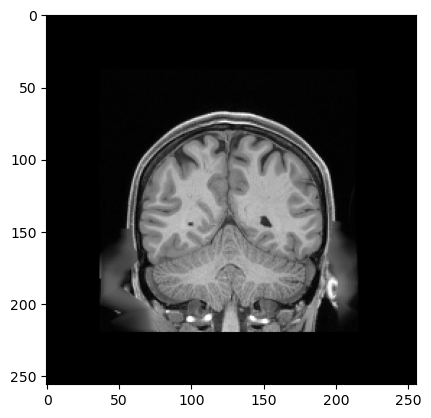

In [3]:
bdata = brain.get_fdata()
plt.imshow(bdata[:,:,100].T, cmap='gray')

In [4]:
annot = nb.load('/Users/benparker/Desktop/cnl/neurocluster/HCP/subjects/100307/mri/lh.PFC_LPC_PMC.nii.gz')
annot = annot.get_fdata()

In [5]:
np.unique(annot)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47.])

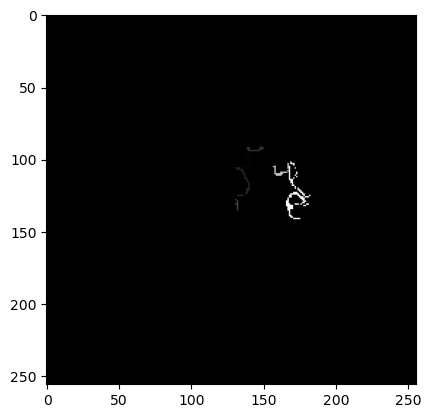

In [6]:
plt.imshow(annot[:,:,100].T, cmap='gray')

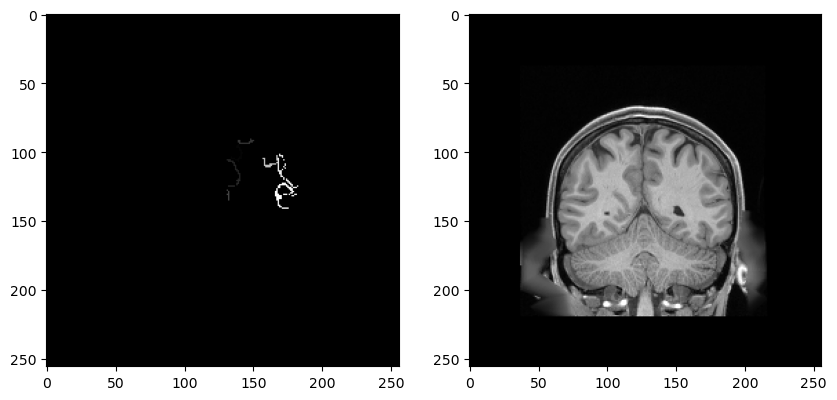

In [7]:
stacked = np.stack([bdata, annot])
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].imshow(stacked[1,:,:,100].T, cmap='gray');
ax[1].imshow(stacked[0,:,:,100].T, cmap='gray');

## Plan  
  
  - load all brains and annotations into dictionary
  - load subject ctab dictionary
  - for each ctab for each hemi, reference main list of sulci for index when all sulci are present
  - for each annotation, reassign voxel values to sulci indexes

In [26]:
subjects_dir = "/Users/benparker/Desktop/cnl/neurocluster/HCP/subjects"
subjects_path_list = fsu.get_subjects_list(subjects_dir=subjects_dir, 
                                           subjects_list="/Users/benparker/Desktop/cnl/neurocluster/HCP/subject_lists/HCP_processed_subs_all.txt")[:18]
# subjects_dir = "/Users/benparker/Desktop/cnl/subjects"
# subjects_path_list = fsu.get_subjects_list(subjects_dir=subjects_dir, 
#                                            subjects_list="/Users/benparker/Desktop/cnl/subjects/subjects_list.txt")[:2]


subjects = [Path(subject_path).name for subject_path in subjects_path_list]

In [27]:
def load_brains_and_annots(subjects_path_list : list, annot_name: str) -> dict:
    """ 
    Loads brain.mgz and {annot}.nii.gz from cluster, saves them under subject name in a dict

    Parameters
    ----------
    subjects_path_list : list - list of subject paths
    annot_name : str - annotation name

    Returns
    -------
    brains : dict - brains.mgz from each subject
    """
    brains = {}
    
    subjects = [Path(subject_path).name for subject_path in subjects_path_list]
    for idx, subject_path in enumerate(subjects_path_list):
        brains[subjects[idx]] = [nb.load(f"{subject_path}/mri/brain.mgz").get_fdata()]
        brains[subjects[idx]].append(nb.load(f"{subject_path}/mri/lh.{annot_name}.nii.gz").get_fdata())
        brains[subjects[idx]].append(nb.load(f"{subject_path}/mri/rh.{annot_name}.nii.gz").get_fdata())
    
    return brains

brains = ppv.load_brains_and_annots(subjects_path_list = subjects_path_list, annot_name='PFC_LPC_PMC')
brains['100307'][0].shape

# brains = ppv.load_brains_and_annots(subjects_path_list = subjects_path_list, annot_name='ribbon')
# brains['100307'][0].shape


(256, 256, 256)

In [28]:
from sys import getsizeof

print(f"{len(subjects)} volumes and annots = {getsizeof(brains)} bytes")

18 volumes and annots = 464 bytes


In [29]:
brains.keys()

dict_keys(['100206', '100307', '100408', '100610', '101006', '101107', '180937', '268749', '365343', '531536', '112920', '176744', '151425', '644044', '128127', '146937', '585256', '867468'])

Load dictionary of subject-hemi sulci

In [30]:
annot_idxs_path = "/Users/benparker/Desktop/cnl/neurocluster/HCP/projects/CNL_scalpel/annot_ctab_json/PFC_LPC_PMC.json"
# annot_idxs_path = "/Users/benparker/Desktop/cnl/subjects/annot_ctab_json/test_annot.json"
with open(annot_idxs_path, 'r', encoding='utf-8') as annot_idxs:
    annot_idxs = json.load(annot_idxs)

annot_idxs['lh_100307'][:10]

['MCGS',
 'POS',
 'prculs',
 'prcus_p',
 'prcus_i',
 'prcus_a',
 'spls',
 'ifrms',
 'sps',
 'icgs_p']

Load all sulci, and add to dictionary of indices

In [31]:

sulci_list = ['MCGS',
        'POS',
        'prculs',
        'prcus_p',
        'prcus_i',
        'prcus_a', 
        'spls', 
        'ifrms',
        'sps',
        'sspls_d', 
        'icgs_p',
        'pmcgs',
        'sspls_v',
        'prculs_v',
        'isms'   ,
        'central',
        'sprs',
        'iprs', 
        'sfs_a', 
        'sfs_p', 
        'pmfs_p', 
        'pmfs_i', 
        'pmfs_a', 
        'ifs', 
        'infs_h', 
        'infs_v',
        'painfs_d', 
        'painfs_v',
        'ds', 
        'aalf', 
        'half', 
        'ts', 
        'prts', 
        'lfms',
        'IPS', 
        'IPS-PO', 
        'SPS', 
        'aipsJ', 
        'sB', 
        'pips', 
        'iTOS', 
        'mTOS', 
        'SmgS', 
        'STS', 
        'cSTS1', 
        'cSTS2', 
        'cSTS3',
        'SLOS', 
        'SLOS2', 
        'SLOS3', 
        'SLOS4'
        ]

all_sulci_idx = {}
for i, sulcus in enumerate(sulci_list):
    all_sulci_idx[sulcus] = i

print(f" Index for MCGS: {all_sulci_idx['MCGS']}\n",
f"Index for cSTS3: {all_sulci_idx['cSTS3']}")

 Index for MCGS: 0
 Index for cSTS3: 46


For each subject hemi, load a create a dict of index mapping as well

For each subject_hemi, find sulcus __incorrect index__ for each sulcus in subject_hemi_sulci_idx and the corresponding __correct index__ in all_sulci_idx.   
  
The for each subject_hemi annot in brains dict, reassign voxel values of incorrect index to correct index.

In [32]:
all_sulci_idx2 = ppv.create_dict_from_list_by_index(sulci_list)


In [33]:
subject_hemi_sulci_idx = ppv.create_subject_hemi_sulci_idx(annot_idxs)

In [35]:
brains_masked = ppv.mask_brains_from_annot(subjects=subjects, brains=brains, all_sulci=sulci_list, 
                                           annot_idxs=annot_idxs, subject_hemi_sulci_idx=subject_hemi_sulci_idx)

: 

: 

In [ ]:
len(brains_masked['100307'])

103

In [ ]:
np.nonzero(brains_masked['100307'][100])

(array([88, 88, 88, 89, 89, 89, 89, 89, 89, 89, 89, 90, 90, 90, 90, 90, 90,
        90, 90, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 92, 92, 92, 92,
        92, 92, 92, 92, 92, 92, 92, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93,
        93, 93, 93, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95,
        95, 95, 95, 95, 95, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96,
        96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 97, 97,
        97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97,
        97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97,
        97, 97, 97, 97, 97, 97, 97, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98,
        98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98,
        98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 99, 99, 99, 99, 99, 99, 99,
        99, 99, 99]),
 array([124, 125, 125, 123, 123, 124, 124, 125, 125, 126, 126, 122

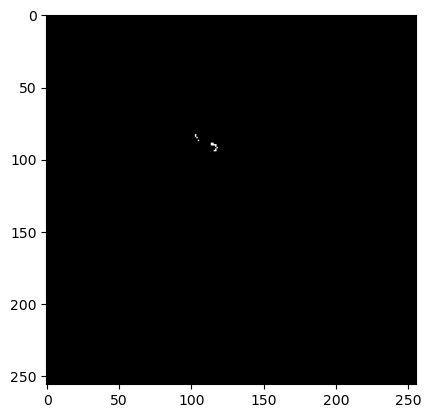

In [ ]:
plt.imshow(brains_masked['100307'][5][131,:,:].T, cmap='gray')  ;

In [ ]:
def plot_brain_and_masks(brain : list) -> None:
    """ 
    Plots brain and masks from a subject

    Parameters
    ----------
    brain : list - brain and masks from a subject
    """
    fig, ax = plt.subplots(3, len(brain) // 3, figsize=(300, 50))

    ax[0, 0].imshow(brain[0][:,:,100].T, cmap='gray')
    ax[0, 0].set_title(f"Volume 0")
    
    for idx, volume in enumerate(brain[1:]):
        nonzero = np.nonzero(volume)
        if np.sum(nonzero) != 0 : 
            try: 
                ax[idx % 3, idx // 3].imshow(volume[:,:, nonzero[2][0]].T, cmap='gray')
                ax[idx % 3, idx // 3].set_title(f"Volume {idx}")
            except IndexError:
                pass
        else: 
            try:
                ax[idx % 3, idx // 3].imshow(volume[:,:,100].T, cmap='gray')
                ax[idx % 3, idx // 3].set_title(f"Volume {idx}")
            except IndexError:
                pass
        
    plt.tight_layout()

In [ ]:
plot_brain_and_masks(brains_masked['100307']) 

This code saves a subject, confirmed as writing the same data on read

In [23]:
# f = h5py.File('/Users/benparker/Desktop/cnl/subjects/test_images.h5', 'w')
# for grp_name in subjects:
#     print(grp_name)
#     grp = f.create_group(grp_name)
#     for idx, volume in enumerate(brains_masked[grp_name]):
#         dset = grp.create_dataset(f'volume_{idx}', (256, 256, 256), dtype='float64' , data = volume)

       
        # print(f'{idx} for {grp_name} is {byte_array[50]}')
        
      

In [24]:
# for subject in subjects:
#     save_file = h5py.File(f"/Users/benparker/Desktop/cnl/neurocluster/HCP/projects/CNL_scalpel/{subject}_images.h5", 'w')
#     print(f"Saving {subject}")
#     print("\n\n\n")
#     for idx, volume in enumerate(brains_masked[subject]):
#         save_file.create_dataset(f'volume_{idx}', (256, 256, 256), dtype='float64' , data = volume)
#         print(f"Saving volume #{idx}")
#         print("\n\n\n")
    

In [25]:
import gc

for sub_idx, subject in enumerate(subjects):
    brain = ppv.load_brains_and_annots(subjects_path_list=subjects_path_list[sub_idx], annot_name='PFC_LPC_PMC')
    all_sulci_idx2 = ppv.create_dict_from_list_by_index(sulci_list)
    subject_hemi_sulci_idx = ppv.create_subject_hemi_sulci_idx(annot_idxs)
    brains_masked = ppv.mask_brains_from_annot(subjects=[subject], brains=brains, all_sulci=sulci_list, 
                                             annot_idxs=annot_idxs, subject_hemi_sulci_idx=subject_hemi_sulci_idx)
    
    save_file = h5py.File(f"/Users/benparker/Desktop/cnl/subjects/{subject}_images.h5", 'w')
    print(f"Saving {subject}")
    print("\n\n\n")
    for idx, volume in enumerate(brains_masked[subject]):
        save_file.create_dataset(f'volume_{idx}', (256, 256, 256), dtype='float64' , data = volume)
        print(f"Saving volume #{idx}")
        print("\n\n\n")
    save_file.close()
    gc.collect()

In [3]:
test_sub = h5py.File('/Users/benparker/Desktop/cnl/subjects/100307_images.h5', 'r')

test_sub.keys()

<KeysViewHDF5 ['volume_0', 'volume_1', 'volume_10', 'volume_100', 'volume_101', 'volume_102', 'volume_11', 'volume_12', 'volume_13', 'volume_14', 'volume_15', 'volume_16', 'volume_17', 'volume_18', 'volume_19', 'volume_2', 'volume_20', 'volume_21', 'volume_22', 'volume_23', 'volume_24', 'volume_25', 'volume_26', 'volume_27', 'volume_28', 'volume_29', 'volume_3', 'volume_30', 'volume_31', 'volume_32', 'volume_33', 'volume_34', 'volume_35', 'volume_36', 'volume_37', 'volume_38', 'volume_39', 'volume_4', 'volume_40', 'volume_41', 'volume_42', 'volume_43', 'volume_44', 'volume_45', 'volume_46', 'volume_47', 'volume_48', 'volume_49', 'volume_5', 'volume_50', 'volume_51', 'volume_52', 'volume_53', 'volume_54', 'volume_55', 'volume_56', 'volume_57', 'volume_58', 'volume_59', 'volume_6', 'volume_60', 'volume_61', 'volume_62', 'volume_63', 'volume_64', 'volume_65', 'volume_66', 'volume_67', 'volume_68', 'volume_69', 'volume_7', 'volume_70', 'volume_71', 'volume_72', 'volume_73', 'volume_74', 'v

In [13]:
sub_dict = {}

for key in test_sub.keys():
    sub_dict[key] = test_sub.get(key)[:]

In [14]:
sub_dict

{'volume_0': array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0

<KeysViewHDF5 ['label', 'label_with_ignore', 'raw']>

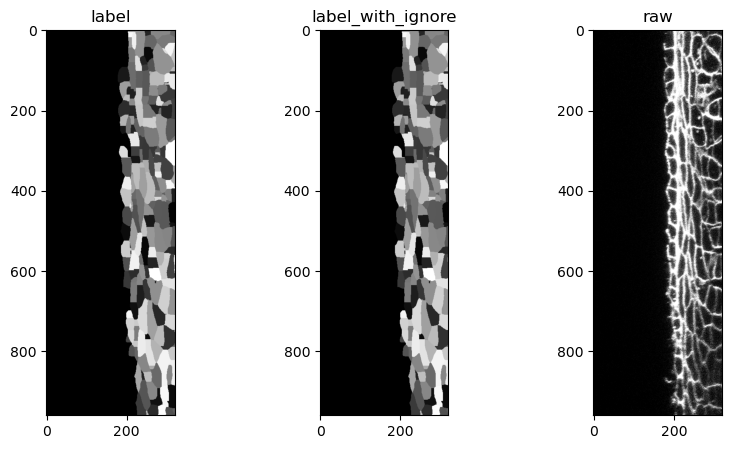

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
for idx, key in enumerate(wolny_data.keys()):
    ax[idx].imshow(wolny_data.get(key)[:, :, 500].T, cmap='gray')
    ax[idx].set_title(key)
    
plt.show()